# Bluesky interfacing demo

This Jupyter Notebook demonstrates the use of Bluesky as a Python package and how it can be used to generate aircraft trajectories.

**Note:** Make sure that you have Bluesky installed as a package in your Python environment.

Let's start by importing the relevant modules.

In [1]:
import numpy as np

import bluesky as bs
from bluesky.simulation import ScreenIO


Using Python-based geo functions


We create a dummy class that acts as the screen of BlueSky. Since we don't want to actually load the screen from BlueSky here, a simple and small class is used instead to avoid errors when something within BlueSky is calling the *echo* function.

In [2]:
class ScreenDummy(ScreenIO):
    """
    Dummy class for the screen. Inherits from ScreenIO to make sure all the
    necessary methods are there. This class is there to reimplement the echo
    method so that console messages are printed.
    """
    def echo(self, text='', flags=0):
        """Just print echo messages"""
        print("BlueSky console:", text)

The first step to take is to initialise bluesky (here imported as *bs*) as a disconnected, single simulation.
Next we replace the screen object with our derived variant so that bluesky console messages are printed.

In [3]:
# initialize bluesky as non-networked simulation node
bs.init(mode='sim', detached=True)

# initialize dummy screen
bs.scr = ScreenDummy()

Reading config from settings.cfg
Creating directory "scenario", and copying default files
Creating directory "plugins", and copying default files
Reading magnetic variation data


Unable to copy "scenario" files to "scenario"
Unable to copy "plugins" files to "plugins"


Loading global navigation database...
Reading cache: data/cache/py3/navdata.p
Error loading plugin: plugin AREA not found.
Error loading plugin: plugin DATAFEED not found.


Now that everything is initialized, we can get started and and generate some traffic. Here, we generate 3 aircraft of the type *A320*.

In [4]:
# generate some trajectories
n = 3

# create n aircraft with random positions, altitudes, speeds
bs.traf.mcre(n, actype="A320")

# alternative: individually initialize each aircraft by passing the initial
# position, heading, altitude, and speed.
# bs.traf.cre(acid=acids, actype=actypes, aclat=aclats, aclon=aclons,
#         achdg=achdgs, acalt=acalts, acspd=acspds)

The traffic in this example are not given any initial conditions such as initial position and velocity. This is not needed when the traffic departs at an airport. You can also pass the initial conditions as additional parameters to the funciton if you want to initialize the traffic in flight.

Next we want to assign some waypoints to the traffic. In this example we assign the same route to all the flights. This is just for the sake of simplicity and it obviously wouldn't make a lot of sense in a practical application, but it should highlight how waypoints are added.

In [5]:
# iterate over traffic and add the same waypoints
# Note that preferably, all simulation commands are initiated through the stack
# however, if you wish, you can also call the functions directly, such as the
# mcre command in the above cell.
for acid in bs.traf.id:
    # set the origin (not needed if initialized in flight),
    # and add some waypoints, here only the altitude (in m) is passed to the
    # function, but you can additionally pass a speed as well
    # finally turn on VNAV for each flight
    bs.stack.stack(f'ORIG {acid} EGLL;'
                   f'ADDWPT {acid} BPK FL60;'
                   f'ADDWPT {acid} TOTRI FL107;'
                   f'ADDWPT {acid} MATCH FL115;'
                   f'ADDWPT {acid} BRAIN FL164;'
                   f'VNAV {acid} ON')

    # you can also set the way the waypoint should be flown
    # bs.stack.stack(f'ADDWPT {acid} FLYOVER')

    # you can also set a destination
    # bs.stack.stack(f'DEST {acid} EHAM')

Now that all our traffic has a route to fly, it's time to start the simulation.

In [6]:
# set simulation time step, and enable fast-time running
bs.stack.stack('DT 1;FF')

# we'll run the simulation for up to 4000 seconds
t_max = 4000

ntraf = bs.traf.ntraf
n_steps = int(t_max + 1)
t = np.linspace(0, t_max, n_steps)

# allocate some empty arrays for the results
res = np.zeros((n_steps, 4, ntraf))

# iteratively simulate the traffic
for i in range(n_steps):
    # Perform one step of the simulation
    bs.sim.step()

    # save the results from the simulator in the results array,
    # here we keep the latitude, longitude, altitude and TAS
    res[i] = [bs.traf.lat,
                bs.traf.lon,
                bs.traf.alt,
                bs.traf.tas]

BlueSky console: Base dt set to 1.0
performance dt is unchanged.
asas dt is unchanged.


Finally, we do a bit of plotting to visualize the results. Again, the three trajectories are the same since we passed the same route to them, but this, of course, can be easily changed.

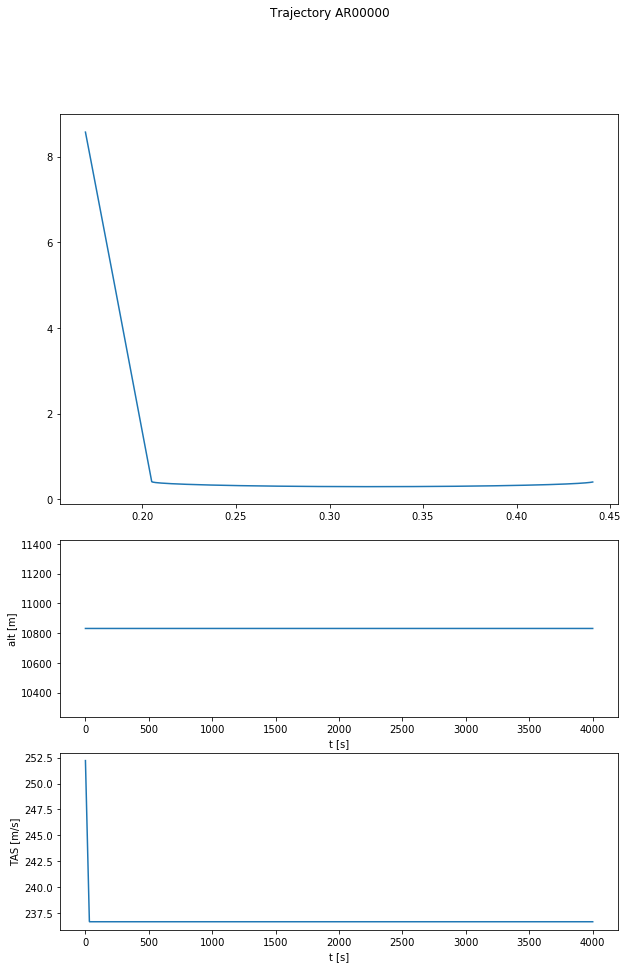

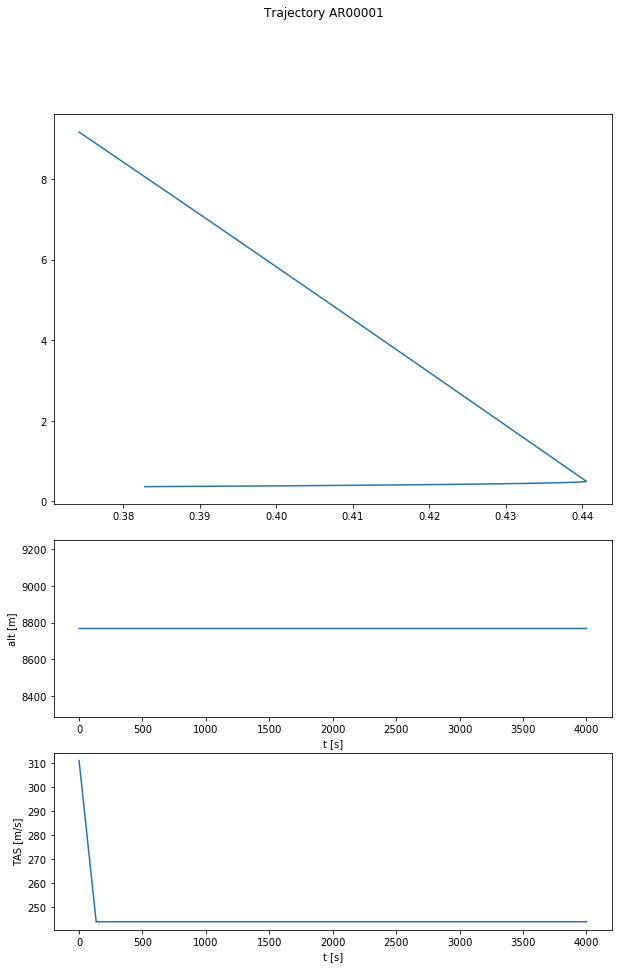

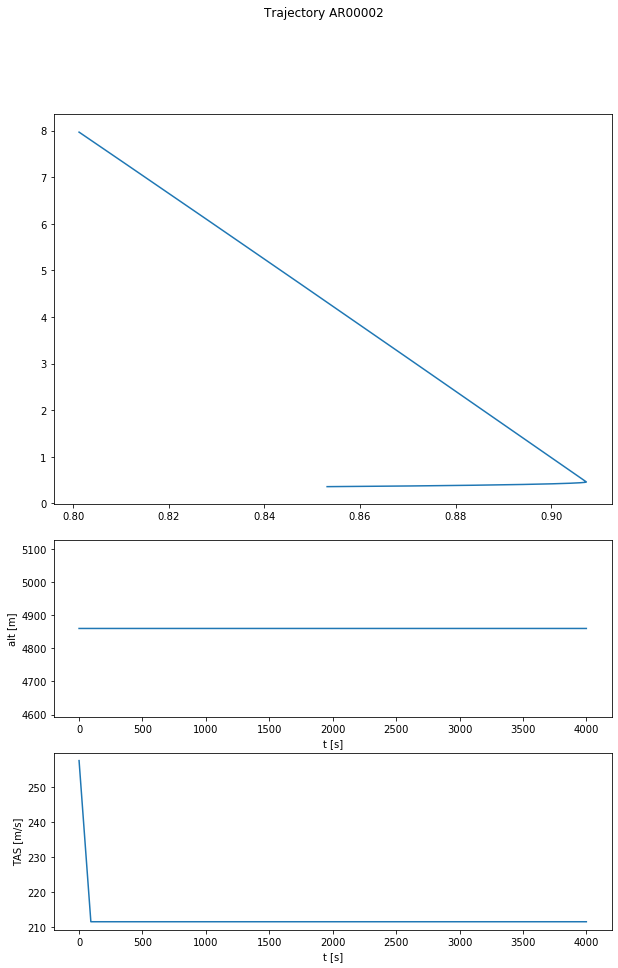

In [8]:
# plot
import matplotlib.pyplot as plt

for idx, acid in enumerate(bs.traf.id):
    fig = plt.figure(figsize=(10, 15))
    ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((4, 1), (2, 0))
    ax3 = plt.subplot2grid((4, 1), (3, 0))

    ax1.plot(res[:, 1, idx], res[:, 0, idx])

    ax2.plot(t, res[:, 2, idx])
    ax2.set_xlabel('t [s]')
    ax2.set_ylabel('alt [m]')

    ax3.plot(t, res[:, 3, idx])
    ax3.set_xlabel('t [s]')
    ax3.set_ylabel('TAS [m/s]')
    
    fig.suptitle(f'Trajectory {acid}')

plt.show()